In [48]:
from fastcore.all import *
import time
import re

def search_images(term, max_size=4000): 
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    pattern = re.search(r'vqd=([\d-]+)\&', res)
    params = {'vqd' : pattern.group(1), 'p': '1', 'o':'json', 'q':term}
    urls, next = set(), ''
    req = url + 'i.js'
    while len(urls) < max_size and next is not None :
        json = urljson(req, data=params)
        urls.update( L(json["results"]).itemgot('image'))
        next =  json["next"] if "next" in json else None
        req = url + str(next)
        time.sleep(1)
    return L(urls)[:max_size]


In [49]:
from fastai.vision.all import *

search = 'bmw', 'mercedes'
path = Path('mercedes_or_bmw')
path2 = Path('mercedes_or_bmw2')

for term in search : 
    (path/term).mkdir(parents=true, exist_ok=true)
    download_images(path/term, urls=search_images(f'{term} photo'))
    resize_images(path/term, dest=path2/term, max_size=400)

/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [50]:
failed = verify_images(get_image_files(path2))
failed.map(Path.unlink)
print(len(failed))

0


In [57]:
ls mercedes_or_bmw2/bmw | wc -l

842


In [59]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]).dataloaders(path2)

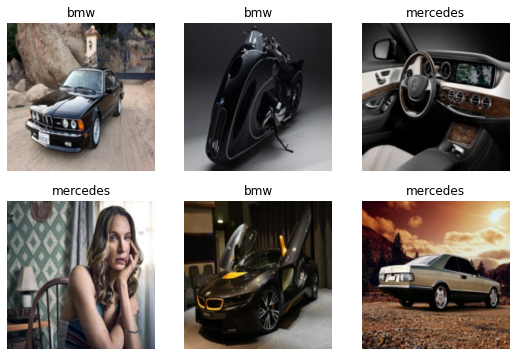

In [60]:
dls.show_batch(max_n=6)

In [61]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.168556,0.827177,0.344633,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.820072,0.719948,0.299435,00:08
1,0.534280,0.803625,0.276836,00:08
2,0.364794,0.792740,0.279661,00:08


In [75]:
category,_,probs = learn.predict(PILImage.create('images/bmw-750.jpeg'))
print(f"This is a: {category}")
print(f"Probability it's a {category}: {probs[0]:.4f}, {probs[1]:.4f}")

This is a: mercedes
Probability it's a mercedes: 0.0266, 0.9734


In [63]:
ls

09b_vision.utils.ipynb  images/         mercedes_or_bmw/
course22/               lesson_1.ipynb  mercedes_or_bmw2/


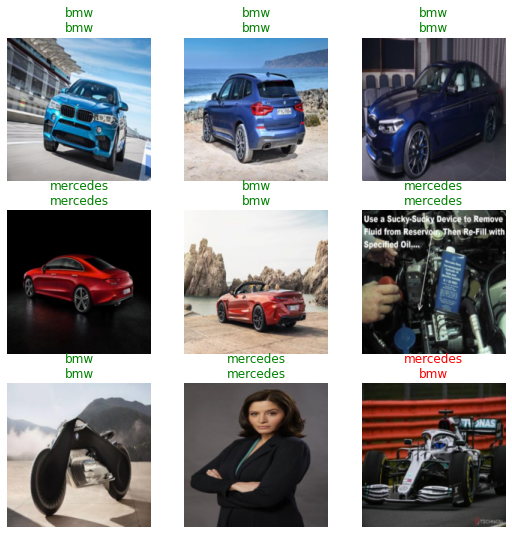

In [74]:
learn.show_results()
